In [201]:
import sklearn
import numpy as np
import matplotlib
import scipy
import pandas as pd
import scipy.stats
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from scipy.stats import normaltest
%matplotlib notebook


# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset
# Carreguem dataset d'exemple
dataset = load_dataset('COMBO17.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

# Per veure les dimensionalitats
print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X:", x.shape)
print("Dimensionalitat de l'atribut Y:", y.shape)

Dimensionalitat de la BBDD: (3462, 65)
Dimensionalitat de les entrades X: (3462, 2)
Dimensionalitat de l'atribut Y: (3462,)


<IPython.core.display.Javascript object>


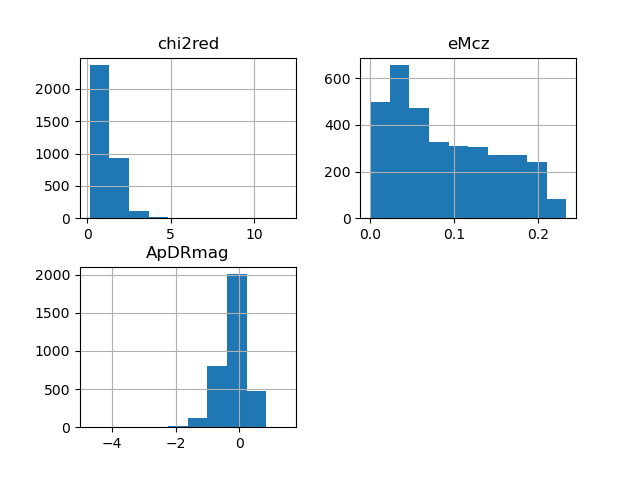

,chi2red,eMcz,ApDRmag
count,3438.000,3438.000,3438.000
mean,1.167,0.090,-0.192
std,0.683,0.062,0.452
min,0.140,0.000,-4.700
25%,0.730,0.036,-0.425
50%,1.020,0.076,-0.141
75%,1.440,0.140,0.088
max,11.910,0.233,1.462


In [202]:
# Eliminem valors inexistents
dataset = dataset.dropna()
dataset = dataset.rename(columns={"e.Mcz": "eMcz"})

#Analisis de chi2red y e.Mcz: la info del dataset indica que los valores demasiado altos corresponden
#a galaxias poco interesantes

#puede ser de interés para representar "chi2red" https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale

hist = dataset[["chi2red", "eMcz", "ApDRmag"]].hist()
dataset[["chi2red", "eMcz", "ApDRmag"]].describe()


<IPython.core.display.Javascript object>


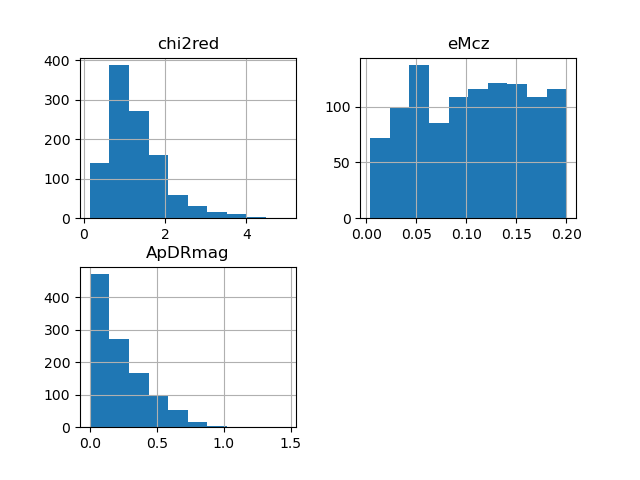

,chi2red,eMcz,ApDRmag
count,1084.000,1084.000,1084.000
mean,1.304,0.107,0.236
std,0.703,0.055,0.200
min,0.150,0.004,0.000
25%,0.830,0.055,0.081
50%,1.140,0.110,0.178
75%,1.620,0.153,0.343
max,4.970,0.200,1.462


In [203]:
dataset = dataset.drop(dataset[dataset.chi2red > 5].index)
dataset = dataset.drop(dataset[dataset.eMcz > 0.2].index)
dataset = dataset.drop(dataset[dataset.ApDRmag < 0].index)

hist = dataset[["chi2red", "eMcz", "ApDRmag"]].hist()
dataset[["chi2red", "eMcz", "ApDRmag"]].describe()

In [204]:
# Drop de la columna 1 que contiene el indice 
dataset = dataset.drop(columns='Nr')

# Quitamos las columnas entre la 56 y la 65 al ser valores redundantes de las 13 anteriores
lst = lst[-10:]


# Creamos una diccionario para seleccionar los nombres de columnas que queremos dropear
dataTypeDict = dict(dataset.dtypes)
lst = []

for x in dataTypeDict:
    if "e" in x:
        lst.append(x)
# Drop de las columnas que den info acerca de los errores        
dataset = dataset.drop(columns = lst)
print("Total de valors no existents:", dataset.isnull().sum().sum())

Total de valors no existents: 0


<IPython.core.display.Javascript object>


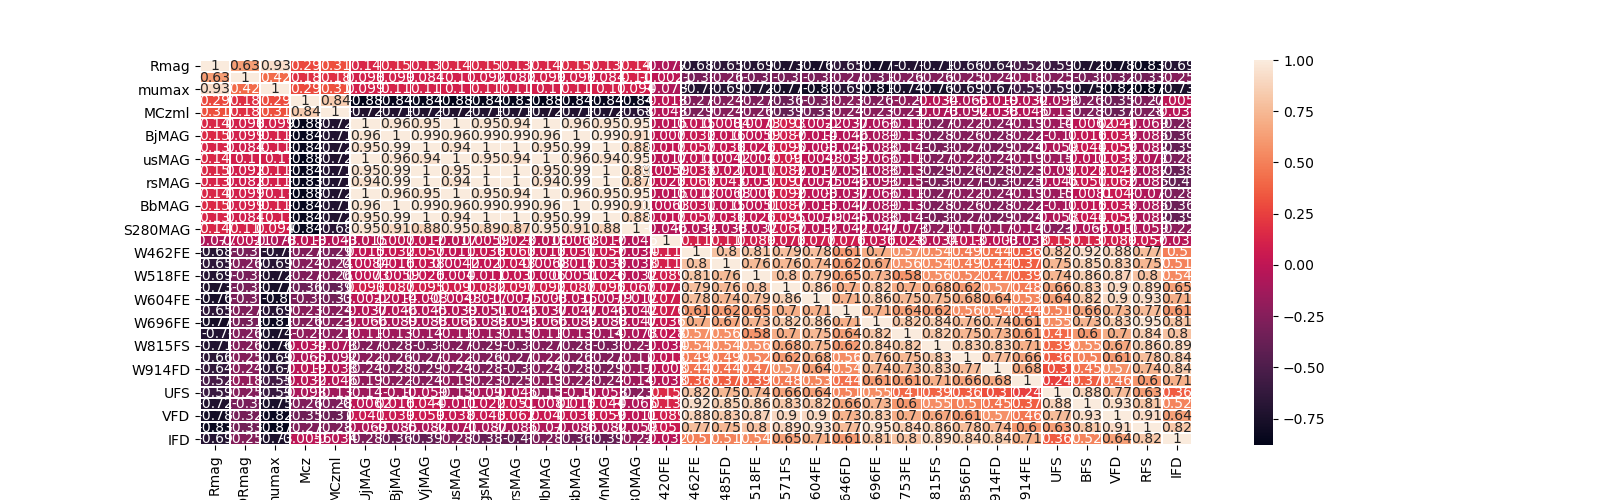

In [205]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()


plt.figure(figsize=(16, 5))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

<IPython.core.display.Javascript object>


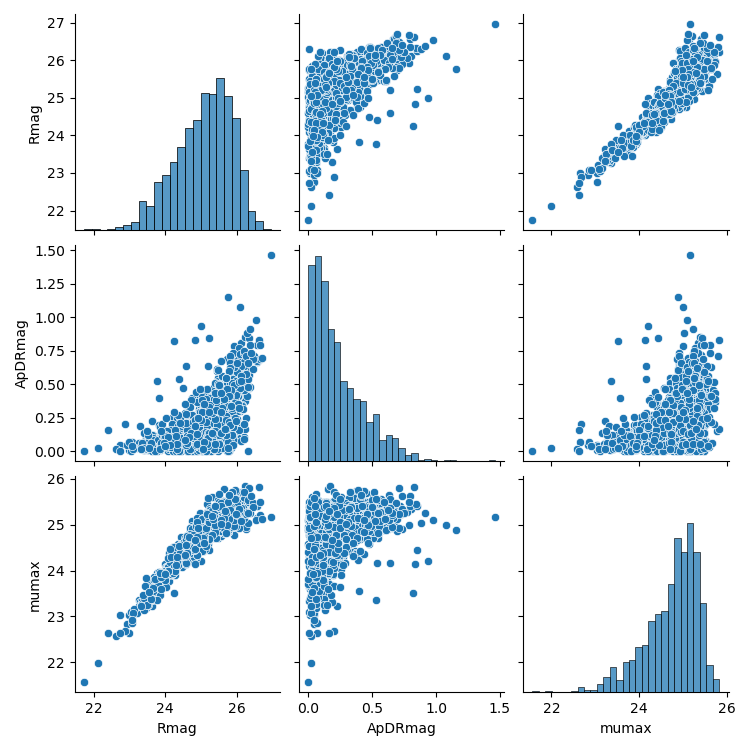

In [206]:
#en el dataset se habla de la correlación entre Rmag y mumax para sacar los tamaños de las galaxias
#si bien es cierto que nos encontramos que cierto grupo de atributos son muc correlativos 
#(el cuadrado ese que se ve, decir las columnas), hay que tener en cuenta que son datos muy parecidos/relacionados (bandas 
#cercanas en la medición), por lo que no se saca mucho de ahí

#comprobamos la correlación entre estos dos datos mediante gráficos

#relacio = sns.pairplot(dataset[["Rmag", "ApDRmag", "Mcz", "mumax"]])

#rel_Rmag_mumax = dataset[["Rmag","mumax"]]
rel_Rmag_mumax = dataset[["Rmag", "ApDRmag", "Mcz", "mumax"]]
rel_Rmag_mumax = dataset[["Rmag", "ApDRmag", "mumax"]]
relacio = sns.pairplot(rel_Rmag_mumax)


<IPython.core.display.Javascript object>


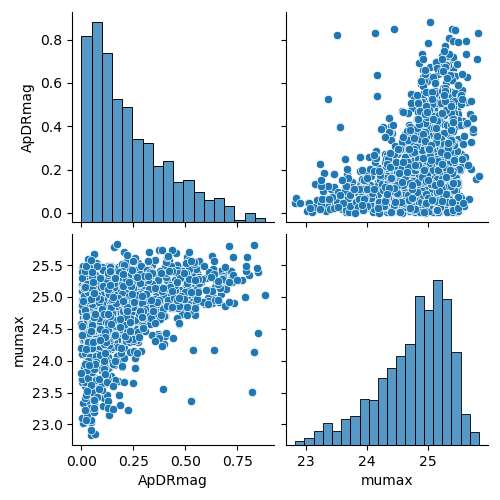

<IPython.core.display.Javascript object>


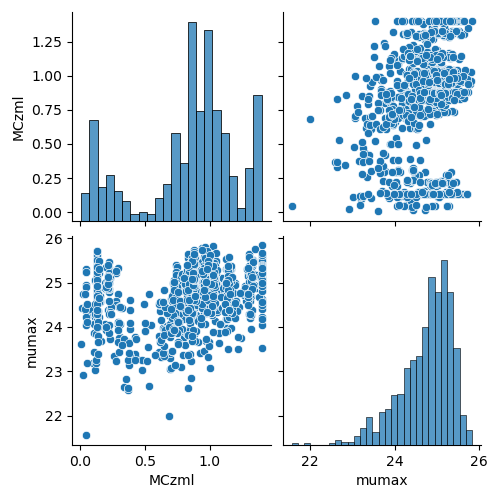

       MCzml  mumax
MCzml  1.000  0.312
mumax  0.312  1.000


In [212]:
#Si bien la correlación es buena, es necesario normalizar los datos para hacerlos más consistentes
#suprimimos los outliers con z_score, que nos indica lo lejos que está cada dato de la media(?) del atributo 
#(https://www.statisticshowto.com/probability-and-statistics/z-score/)

clean_Rmag = dataset[["Rmag", "mumax"]]
clean_ApDRmag = dataset[["ApDRmag", "mumax"]]
clean_Mcz = dataset[["MCzml", "mumax"]]

from scipy import stats
clean_Rmag2 = clean_Rmag[(np.abs(stats.zscore(clean_Rmag)) < 2.25).all(axis=1)]
clean_ApDRmag2 = clean_ApDRmag[(np.abs(stats.zscore(clean_ApDRmag)) < 3.25).all(axis=1)]
clean_Mcz2 = clean_Mcz[(np.abs(stats.zscore(clean_Mcz)) < 3).all(axis=1)]

#comprobamos la correlación entre estos dos datos mediante gráficos
#relacio = sns.pairplot(clean_Rmag2)
relacio = sns.pairplot(clean_ApDRmag2)
relacio = sns.pairplot(clean_Mcz)

correlacio = clean_Mcz.corr()
print(correlacio)



In [213]:
#Hacemos la separación entre datos de test y datos de training

from sklearn.model_selection import train_test_split

test_size = 0.33

ds = rel_Rmag_mumax

#x = ds[["Rmag", "Mcz"]]
x = ds[["Rmag", "ApDRmag", "mumax"]]
y = ds["mumax"]


In [214]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr

def predict_with_train(x, y, test_size):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    model = regression(x, y)
    y_hat = model.predict(x)
    
    # Mostramos el resultado
    plt.figure()
    plt.plot(x, y,'-o', alpha = 0.25)
    plt.plot(x, y_hat, 'r', alpha = 0.25)
    plt.xlabel('mumax')
    plt.ylabel('')

    print ("MSE:", metrics.mean_squared_error(y_hat, y))
    print ("R^2:", metrics.r2_score(y_hat, y))


<IPython.core.display.Javascript object>


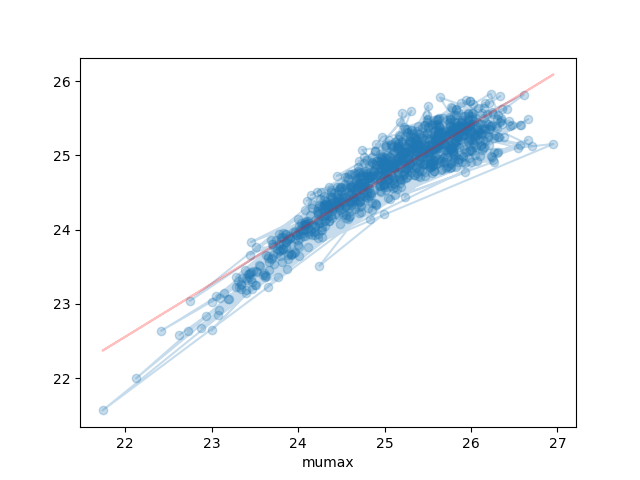

MSE: 0.05195855439778569
R^2: 0.8358775344215198


<IPython.core.display.Javascript object>


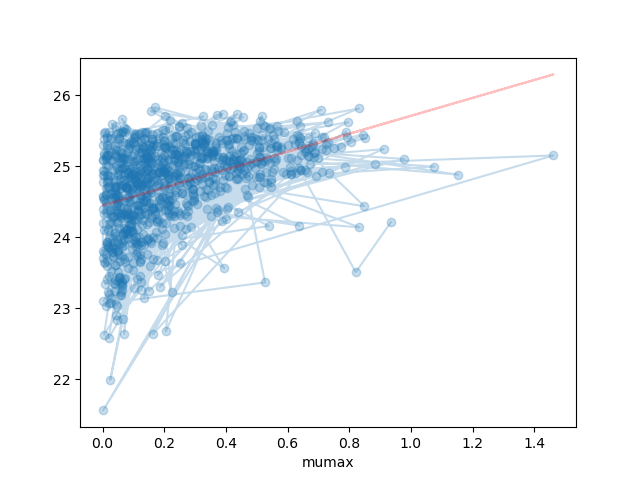

MSE: 0.30456439466033214
R^2: -3.7604396714542236


In [222]:
#Primera regresión
#model = regression(x_train, y_train)
#y_hat = model.predict(x_test)

test_size = 0.33

y = ds["mumax"]
#x = ds
#predict_with_train(x, y, test_size)

x = ds[["Rmag"]]
predict_with_train(x, y, test_size)

x = ds[["ApDRmag"]]
predict_with_train(x, y, test_size)

#x = ds[["Mcz"]]
#predict_with_train(x, y, test_size)


In [ ]:
#pendiente a probar: https://www.w3schools.com/python/python_ml_polynomial_regression.asp